# Spotify logistic regression

As we can see, our extracted dataset is clearly classified and sorted. Hence moving forward, we will be applying “PredictIve Analysis” in order to forecast whether the song which user will be inputting is of their match to not. As we can see with our data - our prediction will have only 2 possible outcomes, wether the person will like the song or not (1 or 0). This will be determined upon set of independent variables provided in the dataset. Hence, it is wise to use “Logistic Regression” for your model.

In [188]:
# Importing necessary modules
from pyspark.sql import SparkSession 
from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as fun
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import accuracy_score
import os, sys
import seaborn as sns

In [186]:
# Creating a spark session
spark = SparkSession.builder.master("local[2]").appName("Spotify_LogisticRegression").getOrCreate()

In [167]:
spark

In [168]:
# Reading the data using spark csv read.
# Setting inferSchema = True. This will help intelligently
# reading the datatypes of all the columns from the csv file itself 
df = spark.read.csv("songs_data.csv", header=True, inferSchema=True)

In [169]:
df.show(5)

+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|_c0|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|liked/disliked|
+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|  1|       0.652| 0.557|1.0|  -5.714| 0.0|     0.0318|        0.74|             0.0|   0.124|  0.483|150.073|             1|
|  2|       0.624| 0.632|1.0| -13.824| 1.0|     0.0534|     0.00517|           0.658|    0.15|  0.334|132.001|             1|
|  3|       0.552| 0.531|7.0|  -7.732| 1.0|     0.0421|       0.241|         1.21E-5|   0.122|  0.438|144.946|             1|
|  4|       0.628| 0.698|6.0|  -5.608| 0.0|      0.105|      0.0472|         0.00143|  0.0907|  0.732| 89.976|             1|
|  5|       0.496| 0.863|9.0|  -4.153| 1.0|     0.0381|      0.0046|             0.0|   0.639|  0.243|110.018|        

23/07/15 22:51:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, liked/disliked
 Schema: _c0, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, liked/disliked
Expected: _c0 but found: 
CSV file: file:///Users/raveeshyadav/GitHub/Spotify-recommendations/songs_data.csv


In [170]:
# First column is a repeat of number of rows. Hence removing it
df = df.drop(fun.col("_c0"))
df.show(5)

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|       0.652| 0.557|1.0|  -5.714| 0.0|     0.0318|        0.74|             0.0|   0.124|  0.483|150.073|             1|
|       0.624| 0.632|1.0| -13.824| 1.0|     0.0534|     0.00517|           0.658|    0.15|  0.334|132.001|             1|
|       0.552| 0.531|7.0|  -7.732| 1.0|     0.0421|       0.241|         1.21E-5|   0.122|  0.438|144.946|             1|
|       0.628| 0.698|6.0|  -5.608| 0.0|      0.105|      0.0472|         0.00143|  0.0907|  0.732| 89.976|             1|
|       0.496| 0.863|9.0|  -4.153| 1.0|     0.0381|      0.0046|             0.0|   0.639|  0.243|110.018|             1|
+------------+------+---

In [187]:
# Printing the schema of our read dataset
df.printSchema()

root
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- liked/disliked: integer (nullable = true)



In [172]:
# All columns except the last column act as features of our dataset. Hence,
# taking an insight of all the columns.
df.select("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo").describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+
|summary|       danceability|            energy|               key|          loudness|              mode|        speechiness|       acousticness|    instrumentalness|           liveness|            valence|             tempo|
+-------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+
|  count|                135|               135|               135|               135|               135|                135|                135|                 135|                135|                135|               135|
|   mean| 0.6131037037037037|0.5853296296296296|  5.42962962962963|-7.641081481481482|0.47407407

In [173]:
# Checking whether the dataset contains any null values or not. Anykind of null values
# in the dataset can cause discrepancy in the model leading to lower accuracy.

df.agg(*[fun.count(fun.when(fun.isnull(column),column)).alias(column)for column in df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|           2|     2|  2|       2|   2|          2|           2|               2|       2|      2|    2|             0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+



In [174]:
# The above result shows that there are null values in our dataset. Hence, we will remove them
df = df.na.drop()

In [175]:
# Re-checking null values

df.agg(*[fun.count(fun.when(fun.isnull(column),column)).alias(column)for column in df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|             0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+



In [176]:
# Selecting the feature columns from the dataset
feature_names = df.columns[:-1]

In [177]:
# Calling VectorAssembler. This creates a single vector columns of all the feature
# columns seleceted in above cell
assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
output = assembler.transform(df).select("features","liked/disliked")

In [178]:
# Displaying top 5 rows of the finalized dataset
output.show(5)

+--------------------+--------------+
|            features|liked/disliked|
+--------------------+--------------+
|[0.652,0.557,1.0,...|             1|
|[0.624,0.632,1.0,...|             1|
|[0.552,0.531,7.0,...|             1|
|[0.628,0.698,6.0,...|             1|
|[0.496,0.863,9.0,...|             1|
+--------------------+--------------+
only showing top 5 rows



In [179]:
# Splitting the data into training and testing model. This will help us 
# assess the data accurately. using 60% data for training and 40% data for testing

finalDataset = output.select("features", "liked/disliked")
train, test = finalDataset.randomSplit([0.6,0.4])

In [180]:
# Preparing the model using training dataset
model_prep = LogisticRegression(featuresCol="features", labelCol="liked/disliked")
songPredictionModel = model_prep.fit(train)

In [181]:
# Applying the trained model on test model
train_pred = songPredictionModel.transform(test)

In [182]:
train_pred.show(10)

+--------------------+--------------+--------------------+--------------------+----------+
|            features|liked/disliked|       rawPrediction|         probability|prediction|
+--------------------+--------------+--------------------+--------------------+----------+
|[0.224,0.5,7.0,-1...|             0|[-0.5026216325657...|[0.37692477349501...|       1.0|
|[0.259,0.437,11.0...|             0|[0.94866870164061...|[0.72084736437167...|       0.0|
|[0.314,0.713,7.0,...|             1|[-0.7031142965784...|[0.33112211022127...|       1.0|
|[0.362,0.155,0.0,...|             0|[2.99452444251374...|[0.95232614552323...|       0.0|
|[0.379,0.0825,3.0...|             0|[0.90785948896935...|[0.71256194836055...|       0.0|
|[0.385,0.265,6.0,...|             1|[3.20739678484938...|[0.96111168444106...|       0.0|
|[0.385,0.464,2.0,...|             1|[-0.3804837642497...|[0.40601022431180...|       1.0|
|[0.425,0.395,4.0,...|             0|[-0.2068953841934...|[0.44845987385219...|       1.0|

In [183]:
# Checking the accuracy of our model ussing sklearn module

y_true = train_pred.select("liked/disliked")
y_true = y_true.toPandas()
#now find the predections
y_pred = train_pred.select("Prediction")
y_pred = y_pred.toPandas()

accuracy_score(y_true, y_pred)

0.6481481481481481

In [184]:
# Printing the confusing matrix for our model. This compare actual values with the model's predicted values
confusion_matrix(y_true, y_pred)

array([[26, 11],
       [ 8,  9]])

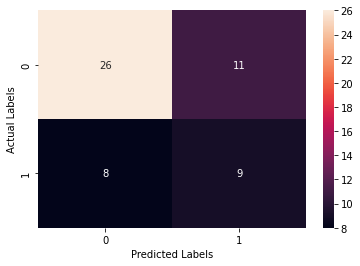

In [185]:
# Printing the confusion matric on a heatmap for better visualisation
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True )
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()